# Topic Modeling of Twitter Statuses with LDA

In [1]:
from gensim import corpora, models, similarities
from pymongo import MongoClient
import time
import os
import random
import numpy as np
import pyLDAvis.gensim
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import warnings
warnings.filterwarnings('ignore')

# Ugly hackery, but necessary: stackoverflow.com/questions/4383571/importing-files-from-different-folder
import sys
sys.path.append('../../')

from src.streaming import spark_functions

corpus_filename = './../../data/processed/tweets_stream.mm'
dict_filename = './../../data/processed/tweets_stream.dict'
lda_filename = './../../models/lda/gensim/tweets_stream.lda'

preprocess = spark_functions.preprocessor()
tokenize = spark_functions.tokenizer(remove_stopwords=True)

## Loading the Corpus and Dictionary

In [2]:
corpus = corpora.MmCorpus(corpus_filename)
dictionary = corpora.Dictionary.load(dict_filename)
num_topics = 10

## Train the LDA model

In [3]:
#lda = models.LdaModel.load(lda_filename)
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics, alpha="auto", eta=0.01)

In [4]:
#lda.print_topics()
lda.save(lda_filename)

## Some Experiments

In [5]:
followers_data =  pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.display(followers_data)

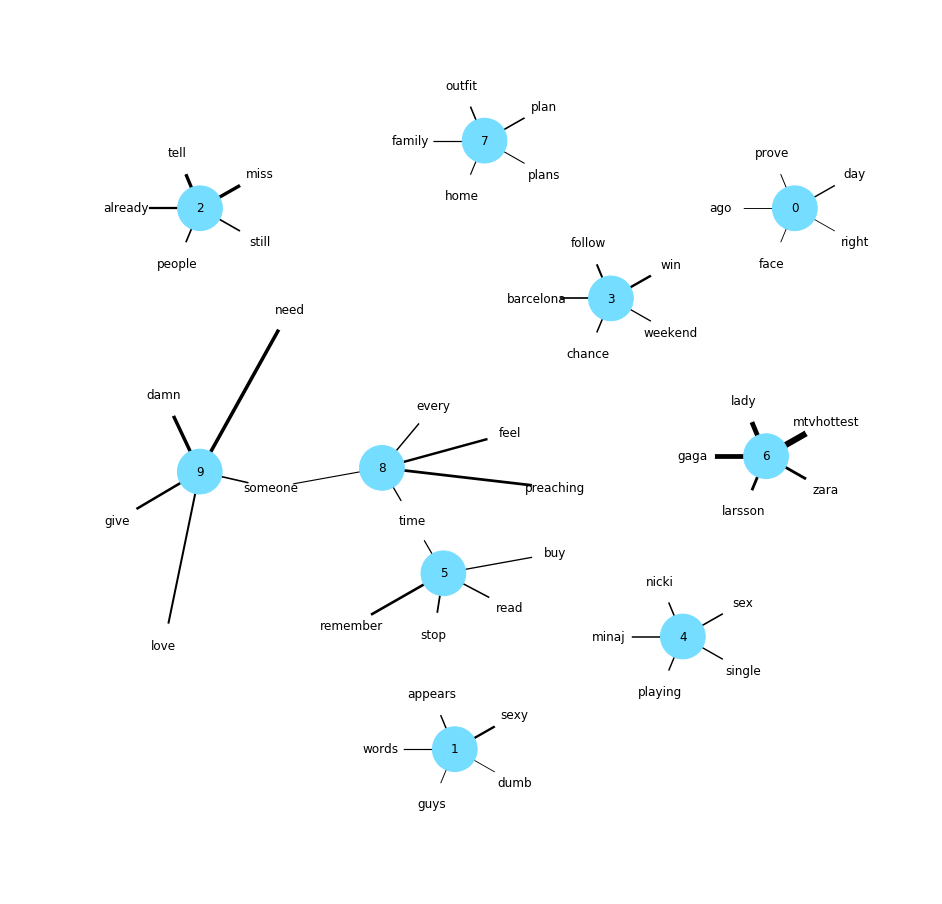

In [6]:
# TODO document
#brew install graphviz
#sudo pip install pygraphviz

graph = nx.Graph()

for i in range(num_topics):    
    for (term_id, term_probability) in lda.get_topic_terms(topicid=i, topn=5):
        graph.add_node(i,color="#75DDFF")
        graph.add_edge(i,dictionary[term_id],weight=term_probability*100)    

plt.figure(figsize=(16,16))

pos = graphviz_layout(graph, prog="twopi", root='1')
nodes = graph.nodes()

# nodes
nodes = graph.nodes(data=True)
colors = [node[1]['color'] if 'color' in node[1] else "#FFFFFF" for node in nodes]
nx.draw_networkx_nodes(graph,pos,node_color=colors, node_size=2000)

# edges
edges = graph.edges()
weights = [graph[u][v]['weight'] for u,v in edges]
nx.draw_networkx_edges(graph,pos,edgelist=edges,width=weights)

# labels
sizes = [16 if 'color' in node[1] else 8 for node in nodes]
nx.draw_networkx_labels(graph,pos,font_size=12,font_family='sans-serif')

plt.axis('off')
plt.savefig('lda_network_graph.pdf', format="pdf")
plt.show()

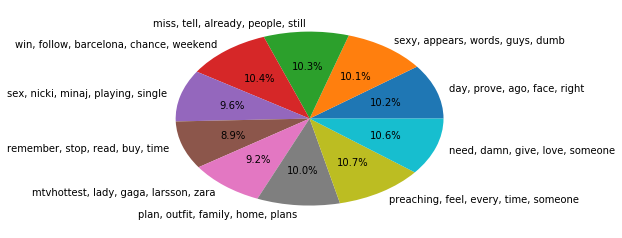

In [11]:
# Pie chart of topics in the sample dataset
db = MongoClient()['thesis-dev']
topic_frequency = defaultdict(int)
for tweet in db.tweets.find():
    
    topics = lda[dictionary.doc2bow(tokenize(preprocess(tweet['text'])))]
    for topic in topics:
        #print(topic)
        topic_frequency[topic[0]] += topic[1]
        

import matplotlib.pyplot as plt
labels,values = [],[]
for key in topic_frequency:
    values.append(topic_frequency[key])
    labels.append(", ".join(dictionary[term_id] for (term_id,_) in lda.get_topic_terms(topicid=key, topn=5)))
plt.pie(values, labels=labels, shadow=False, autopct='%1.1f%%',)
plt.savefig('topic_distribution.pdf', format="pdf")
plt.show()

In [76]:
def print_topics(text):
    doc_bow = [dictionary.doc2bow(text) for text in [tokenize(preprocess(text))]]
    topics = lda[doc_bow][0]

    print(text)
    for topic in topics:  # Maximum 3 Topics per tweet
        terms = lda.get_topic_terms(topicid=topic[0], topn=5) # Maximum 5 Terms per tweet
        print("Probability %d%%: %s" % (topic[1]*100, ", ".join(dictionary[term[0]] for term in terms)))
        
print_topics("lol i hate the stupid #iphone")
print_topics("android is pretty cool I guess, with the new ice cream sandwich update")

lol i hate the stupid #iphone
Probability 20%: ballmer, lol, yahoo, steve, xbox
Probability 35%: contact, builds, net, multiple, product
Probability 24%: research, systems, nov, service, links
android is pretty cool I guess, with the new ice cream sandwich update
Probability 11%: faster, register, security, personal, wall
Probability 66%: android, ice, cream, sandwich, deals
Probability 11%: windows, sex, phone, mango, try
